
# Custom refit strategy of a grid search with cross-validation

This examples shows how a classifier is optimized by cross-validation,
which is done using the :class:`~sklearn.model_selection.GridSearchCV` object
on a development set that comprises only half of the available labeled data.

The performance of the selected hyper-parameters and trained model is
then measured on a dedicated evaluation set that was not used during
the model selection step.

More details on tools available for model selection can be found in the
sections on `cross_validation` and `grid_search`.


## The dataset

We will work with the `digits` dataset. The goal is to classify handwritten
digits images.
We transform the problem into a binary classification for easier
understanding: the goal is to identify whether a digit is `8` or not.



### import

In [10]:
from sklearn import datasets

digits = datasets.load_digits()
digits.data.shape

(1797, 64)

### plot

<Figure size 432x288 with 0 Axes>

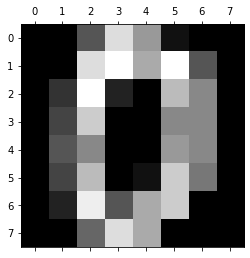

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [11]:
import matplotlib.pyplot as plt

plt.gray()
plt.matshow(digits.images[0])
plt.show()

digits.images[0]

### flatten

In order to train a classifier on images, we need to flatten them into vectors.
Each image of 8 by 8 pixels needs to be transformed to a vector of 64 pixels.
Thus, we will get a final data array of shape `(n_images, n_pixels)`.



(1797, 64)
The number of images is 1797 and each image contains 64 pixels


array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

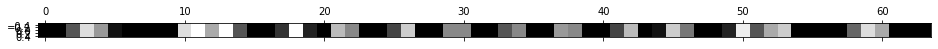

In [12]:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target == 8

plt.matshow([X[0]])

print(X.shape)
print(f"The number of images is {X.shape[0]} and each image contains {X.shape[1]} pixels")
X[0]

As presented in the introduction, the data will be split into a training
and a testing set of equal size.



In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

## Define our grid-search strategy

We will select a classifier by searching the best hyper-parameters on folds
of the training set. To do this, we need to define
the scores to select the best candidate.



In [14]:
scores = ["precision", "recall"]

We can also define a function to be passed to the `refit` parameter of the
:class:`~sklearn.model_selection.GridSearchCV` instance. It will implement the
custom strategy to select the best candidate from the `cv_results_` attribute
of the :class:`~sklearn.model_selection.GridSearchCV`. Once the candidate is
selected, it is automatically refitted by the
:class:`~sklearn.model_selection.GridSearchCV` instance.

Here, the strategy is to short-list the models which are the best in terms of
precision and recall. From the selected models, we finally select the fastest
model at predicting. Notice that these custom choices are completely
arbitrary.



In [15]:
import pandas as pd


def print_dataframe(filtered_cv_results):
    """Pretty print for filtered dataframe"""
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results["mean_test_precision"],
        filtered_cv_results["std_test_precision"],
        filtered_cv_results["mean_test_recall"],
        filtered_cv_results["std_test_recall"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()


def refit_strategy(cv_results):
    """Define the strategy to select the best estimator.

    The strategy defined here is to filter-out all results below a precision threshold
    of 0.98, rank the remaining by recall and keep all models with one standard
    deviation of the best by recall. Once these models are selected, we can select the
    fastest model to predict.

    Parameters
    ----------
    cv_results : dict of numpy (masked) ndarrays
        CV results as returned by the `GridSearchCV`.

    Returns
    -------
    best_index : int
        The index of the best estimator as it appears in `cv_results`.
    """
    # print the info about the grid-search for the different scores
    precision_threshold = 0.98

    cv_results_ = pd.DataFrame(cv_results)
    print("All grid-search results:")
    print_dataframe(cv_results_)

    # Filter-out all results below the threshold
    high_precision_cv_results = cv_results_[
        cv_results_["mean_test_precision"] > precision_threshold
    ]

    print(f"Models with a precision higher than {precision_threshold}:")
    print_dataframe(high_precision_cv_results)

    high_precision_cv_results = high_precision_cv_results[
        [
            "mean_score_time",
            "mean_test_recall",
            "std_test_recall",
            "mean_test_precision",
            "std_test_precision",
            "rank_test_recall",
            "rank_test_precision",
            "params",
        ]
    ]

    # Select the most performant models in terms of recall
    # (within 1 sigma from the best)
    best_recall_std = high_precision_cv_results["mean_test_recall"].std()
    best_recall = high_precision_cv_results["mean_test_recall"].max()
    best_recall_threshold = best_recall - best_recall_std

    high_recall_cv_results = high_precision_cv_results[
        high_precision_cv_results["mean_test_recall"] > best_recall_threshold
    ]
    print(
        "Out of the previously selected high precision models, we keep all the\n"
        "the models within one standard deviation of the highest recall model:"
    )
    print_dataframe(high_recall_cv_results)

    # From the best candidates, select the fastest model to predict
    fastest_top_recall_high_precision_index = high_recall_cv_results[
        "mean_score_time"
    ].idxmin()

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on precision and recall.\n"
        "Its scoring time is:\n\n"
        f"{high_recall_cv_results.loc[fastest_top_recall_high_precision_index]}"
    )

    return fastest_top_recall_high_precision_index

## Tuning hyper-parameters

Once we defined our strategy to select the best model, we define the values
of the hyper-parameters and create the grid-search instance:



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]

grid_search = GridSearchCV(
    SVC(), tuned_parameters, scoring=scores, refit=refit_strategy
)
grid_search.fit(X_train, y_train)

The parameters selected by the grid-search with our custom strategy are:



In [ ]:
grid_search.best_params_

Finally, we evaluate the fine-tuned model on the left-out evaluation set: the
`grid_search` object **has automatically been refit** on the full training
set with the parameters selected by our custom refit strategy.

We can use the classification report to compute standard classification
metrics on the left-out set:



In [ ]:
from sklearn.metrics import classification_report

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

<div class="alert alert-info"><h4>Note</h4><p>The problem is too easy: the hyperparameter plateau is too flat and the
   output model is the same for precision and recall with ties in quality.</p></div>

